<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.utils import shuffle


RND_SEED = 12345
FAST_MODE = False
# Включенный FAST_MODE будет обучать модели без перебора параметров, 
# используя заранее определенный набор, результат дает хуже, но не нужно ждать.
# Если есть время на обучение (20 мин на 8 потоках) то можно перевести в False


## Подготовка данных

In [2]:
try:
    data = pd.read_csv('/Users/evgeniu/Desktop/Education/Practicum/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data['Exited'].sum()

2037

У нас есть 10к строк с клиентами банка, 2к из которых ушли.

In [6]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
data[data['Tenure'].isna() & data['Exited'] == 1]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
125,126,15627360,Fuller,432,France,Male,42,NaN,152603.45,1,1,0,110265.24,1
237,238,15764866,Synnot,539,Germany,Female,43,NaN,116220.50,3,1,0,55803.96,1
357,358,15661629,Ricci,522,Spain,Male,34,NaN,126436.29,1,1,0,174248.52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,9338,15797751,Pai,466,Germany,Female,47,NaN,102085.72,1,1,1,183536.24,1
9466,9467,15592716,Clarke,559,France,Male,52,NaN,0.00,1,1,0,129013.59,1
9652,9653,15726720,Blinova,480,France,Female,40,NaN,0.00,1,1,0,170332.67,1
9858,9859,15619514,Bull,507,Germany,Male,40,NaN,120105.43,1,1,0,92075.01,1


Среди данных есть 909 пропусков в Tenure, 183 из них ушли

In [8]:
display(data[data['Exited'] == 1]['Tenure'].mean(), data[data['Exited'] == 0]['Tenure'].mean())

4.901833872707659

5.022246787342822

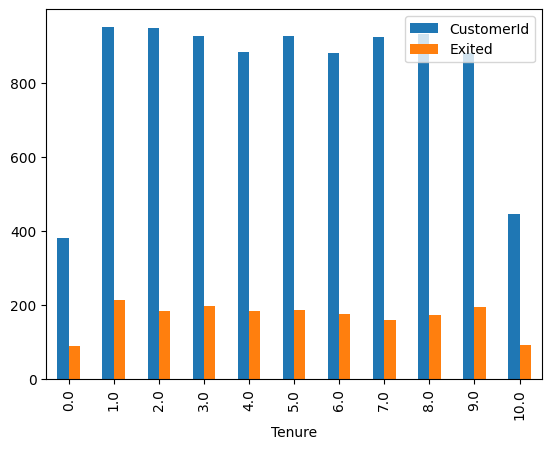

In [9]:
data.pivot_table(index='Tenure', values=['CustomerId', 'Exited'], aggfunc={'CustomerId': 'count', 'Exited': 'sum'}).plot(kind='bar');

По гистограмме видно, что клиенты уходят не зависимо от времени работы с банком. Распределение равномерное. Удалять строки не хочется, это 10%. Заполнение усредненным единым значением даст сильный всплеск в распределении. Для заполнения пропусков можно использовать метод линейной регрессии. К нему я вернусь после подготовки данных. 

In [10]:
data.duplicated().sum()

0

## Исследование задачи

In [11]:
len(data['Surname'].unique())

2932

3000 уникальных фамилии. Для модели эти записи ничего не значат.

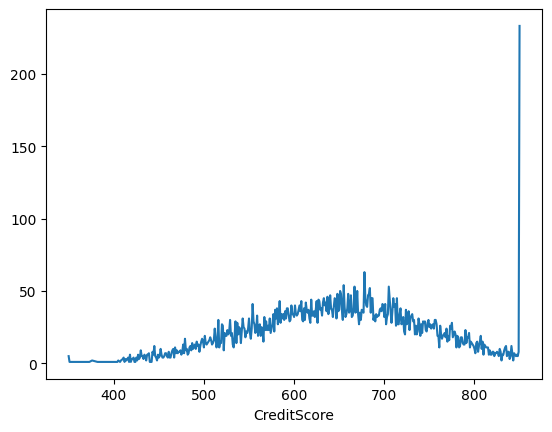

In [12]:
data.groupby(['CreditScore'])['CustomerId'].count().plot();

Здесь что-то невнятное по рейтингу у 900

In [13]:
data.groupby(['CreditScore'])['CustomerId'].count().sort_values(ascending=False).head(10)

CreditScore
850    233
678     63
655     54
705     53
667     53
684     52
651     50
670     50
648     48
660     48
Name: CustomerId, dtype: int64

Кто-то подкрутил клиентам банка рейтинг. Взглянем на этих "любимчиков" банка.

In [14]:
data[data['CreditScore'] == 850].iloc[:, -6:].sum()/data[data['CreditScore'] == 850].iloc[:, -6:].count()

Balance            78718.993219
NumOfProducts          1.515021
HasCrCard              0.699571
IsActiveMember         0.549356
EstimatedSalary    95919.323777
Exited                 0.184549
dtype: float64

In [15]:
data.iloc[:, -6:].sum()/data.iloc[:, -6:].count()

Balance             76485.889288
NumOfProducts           1.530200
HasCrCard               0.705500
IsActiveMember          0.515100
EstimatedSalary    100090.239881
Exited                  0.203700
dtype: float64

Клинты с рейтингом 850 не отличаются от всех остальных, это просто люди с идеальной кредитной историей

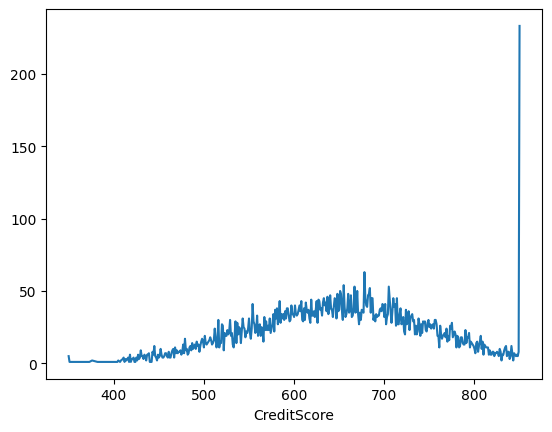

In [18]:
data.groupby(['CreditScore'])['CustomerId'].count().plot();

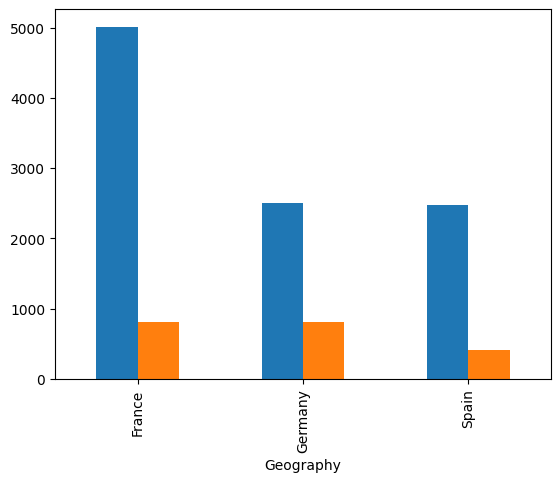

In [19]:
data.pivot_table(index='Geography', values=['CustomerId', 'Exited'], 
                 aggfunc={'CustomerId': 'count', 'Exited': 'sum'})\
                .plot(kind='bar', legend=None);

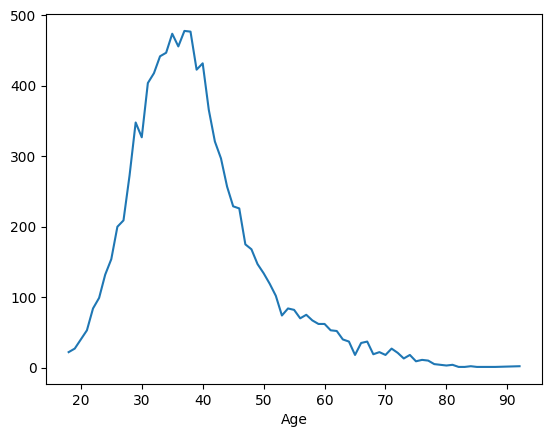

In [20]:
data.groupby(['Age'])['Age'].count().plot();

График показывает количество клиентов по возрастам

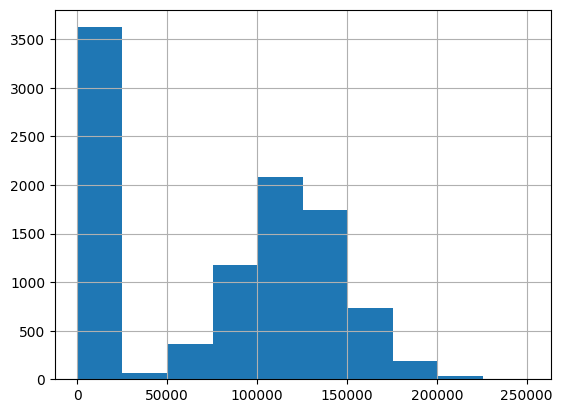

In [21]:
data['Balance'].hist();

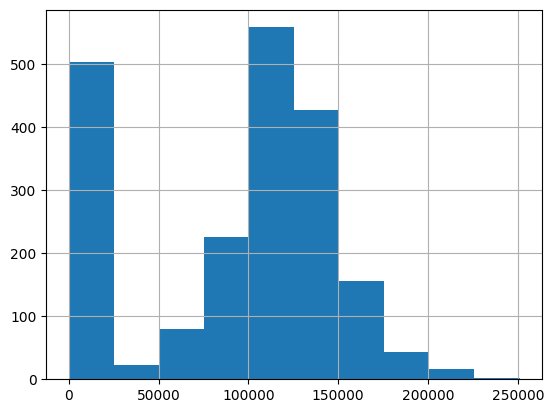

In [22]:
data[data['Exited'] == 1]['Balance'].hist();

Распределение баланса денежных средств.

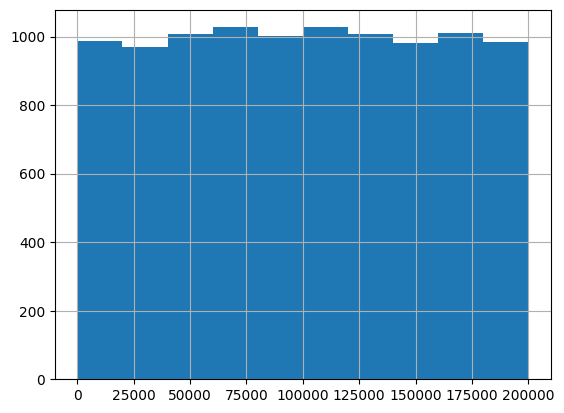

In [23]:
data['EstimatedSalary'].hist();

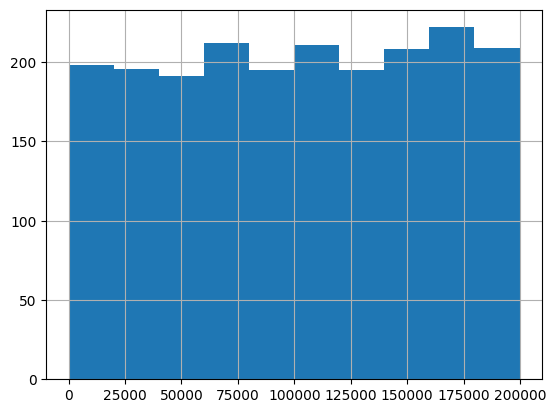

In [24]:
data[data['Exited'] == 1]['EstimatedSalary'].hist();

Стена распределения зарплат. Зависимость среди вышедших слабая.

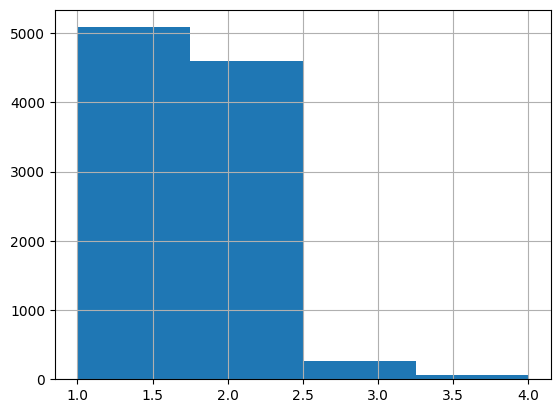

In [25]:
data['NumOfProducts'].hist(bins=4);

Обычно у клиента 1-2 продукта

### Заполнение пропусков методом линейной регрессии

In [26]:
na_data = data.copy()
na_data = na_data.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1)
na_data['Tenure'] = na_data['Tenure'].fillna(0)

In [27]:
# В тесте записи с пустым Tenure
test = na_data[data['Tenure'].isna()]
test.shape

(909, 11)

In [28]:
# Тренируем модель на полных записях
train = na_data[~data['Tenure'].isna()]
train.shape

(9091, 11)

In [29]:
y_train = train['Tenure']
X_train = train.drop('Tenure', axis=1)

X_test = test.drop('Tenure', axis=1)
# y_test не требуется

In [30]:
# Порядковое кодирование строковых значений
def replacer(set, col, encoder=False):
    if encoder == False:
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoder.fit(set[col])
    res = pd.DataFrame(encoder.transform(set[col]))
    set = set.drop(col, axis = 1)
    return pd.DataFrame(np.concatenate((res, set), axis=1))

def transform_data(train_set, test_set, OHEcol, scale=True):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoder.fit(train_set[OHEcol])

    train_set_OHE = replacer(train_set, OHEcol, encoder)
    test_set_OHE = replacer(test_set, OHEcol, encoder)
    if scale:
        scaler = StandardScaler()
        scaler.fit(train_set_OHE)
        train_tf = pd.DataFrame(scaler.transform(train_set_OHE), columns = train_set_OHE.columns)
        test_tf = pd.DataFrame(scaler.transform(test_set_OHE), columns = test_set_OHE.columns)
        return train_tf, test_tf
    else:
        return train_set_OHE, test_set_OHE


In [31]:
X_train_tf, X_test_tf = transform_data(X_train, X_test, ['Geography', 'Gender'])
print(X_train_tf.head(3),'\n', X_test_tf.head(3))

        0         1         2         3         4         5         6   \
0 -0.58078 -0.573159 -1.099164 -0.329200  0.289040 -1.227780 -0.912601   
1 -0.58078  1.744717 -1.099164 -0.443301  0.194298  0.116887 -0.912601   
2 -0.58078 -0.573159 -1.099164 -1.542828  0.289040  1.333920  2.529911   

         7        8         9         10  
0  0.646896  0.96934  0.020264  1.975716  
1 -1.545844  0.96934  0.214527 -0.506146  
2  0.646896 -1.03163  0.238632  1.975716   
          0         1         2         3         4         5         6   \
0 -0.580780  1.744717 -1.099164 -0.619641  0.004815 -1.227780  2.529911   
1  1.721823 -0.573159  0.909782 -1.044929 -0.089927  0.431098 -0.912601   
2  1.721823 -0.573159  0.909782 -0.681878 -0.279411  1.115556  0.808655   

         7        8         9         10  
0  0.646896 -1.03163  0.699185  1.975716  
1 -1.545844  0.96934 -0.161451 -0.506146  
2 -1.545844 -1.03163 -0.238741 -0.506146  


In [32]:

# обучаем предсказываем применяем
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(X_train_tf, y_train)
y_pred = lr_model.predict(X_test_tf)
 
test['Tenure'] = y_pred

/var/folders/8v/rm1bmfds00g00p2x5xhkmm1r0000gn/T/ipykernel_23534/3112236381.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Tenure'] = y_pred


In [33]:
#собираем данные обратно в кучу
data_lr = pd.concat([train, test])
data_lr.sort_index(inplace=True)
#lr.tail(5)

count    909.000000
mean       0.001031
std        0.146366
min       -0.411721
25%       -0.092453
50%        0.000462
75%        0.110036
max        0.328060
Name: Tenure, dtype: float64

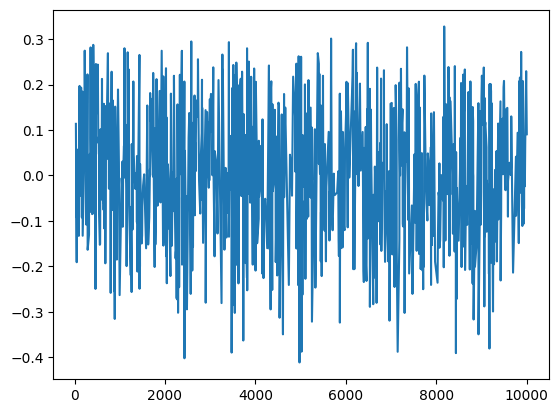

In [34]:
# вернем исходный масштаб с помощью метода .inverse_transform()
#lr_ordinal = pd.DataFrame(scaler.inverse_transform(so_lr), columns = so_lr.columns)

display(data_lr[data['Tenure'].isna()]['Tenure'].describe())
data_lr[data['Tenure'].isna()]['Tenure'].plot();

Модель предсказала значения близкие к 0, с небольшими отклонениями. Если округлить предсказаные значения, то мы получим средние 5 лет и создадим всплеск. 

Есть мысль "усилить" дисперсию, что-бы получить распределение похожее на известные данные. Грязно, но лучше чем рандом 0,10.

In [35]:
data_lr.loc[data['Tenure'].isna(), 'Tenure'] = ((data_lr[data['Tenure'].isna()]['Tenure']* 10) + 5).round(0)

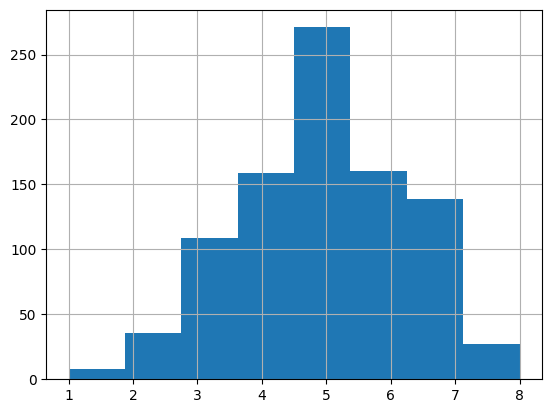

In [36]:
data_lr.loc[data['Tenure'].isna()]['Tenure'].hist(bins=8);

Получили распределение похожее на нормальное.Навредить не должно.

In [37]:
data_lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 937.5+ KB


### Заполнение пропусков методом расчета ближайших соседей

In [38]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")

In [39]:
na_data.loc[data['Tenure'].isna(), 'Tenure'] = np.nan #Вернем nan
knn = pd.DataFrame(imputer.fit_transform(replacer(na_data, ['Geography', 'Gender'])))
data_knn = na_data.copy()
data_knn.loc[data['Tenure'].isna(), 'Tenure']=knn[5]

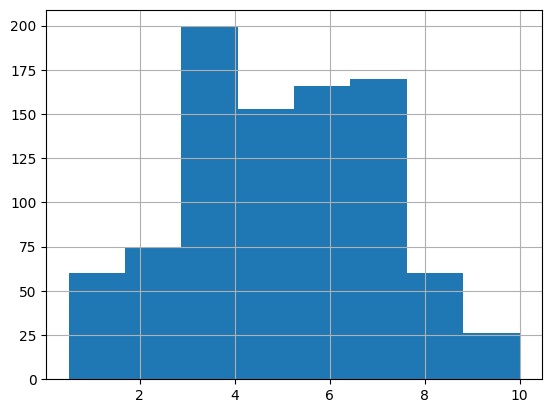

In [40]:
data_knn.loc[data['Tenure'].isna()]['Tenure'].hist(bins=8);

Этот метод дал распределение ближе к исходному.

### Первые модели

#### Подготовка

In [41]:
#Делаем наборы данных для датасетов.
#Сплит на обучение и тест. Тестовые данные не определяются так как обучение будет проходить с применением кросс-валидации.
def prepare_data(dt):
    y = data['Exited']
    X = dt.drop('Exited', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25, random_state=RND_SEED)
    return X_train, X_test, y_train, y_test

In [42]:
#Подготовка параматров для обучения
solvers = [LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier()]

if (not FAST_MODE):
    params = [    
        #LogisticRegression
        {'penalty' : ['l2'],
        'C' : np.logspace(-4, 2, 20),
        'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
        'max_iter' : [100, 1000, 2500, 5000]
        },
        #DecisionTreeClassifier
        {'criterion' : ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2'],
        'max_depth': range (5,10, 1),
        'min_samples_leaf': range (1,8),
        'min_samples_split': range (2,10,2),
        'random_state': [RND_SEED]
        },
        #RandomForestClassifier
        {'criterion' : ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2'],
        'n_estimators': range (20, 70, 8),
        'max_depth': range (5,10, 1),
        'min_samples_leaf': range (1,6,2),
        'min_samples_split': range (2,8,2),
        'random_state': [RND_SEED]
        }
    ]
else:
    params = [
        #LogisticRegression
        {'C' : [0.007847599703514606],
        'penalty' : ['l1'],
        'solver' : ['liblinear']
        },
        #DecisionTreeClassifier
        {'max_depth' : [6], 
        'min_samples_leaf' : [7],
        'max_features' : ['sqrt'], 
        'random_state' : [RND_SEED]
        },
        #RandomForestClassifier
        {'criterion': ['gini'],
        'max_depth': [9],
        'max_features': ['sqrt'],
        'min_samples_leaf': [1],
        'min_samples_split': [4],
        'n_estimators': [44],
        'random_state': [RND_SEED]
        }


    ]

In [43]:
#Уичм три модели с подбором параметров
def trener(X, y):
    models = []
    for solver, param in zip(solvers, params):
        grid = GridSearchCV(solver, param, cv=5, verbose=True, n_jobs=-1, scoring='f1')
        grid.fit(X, y)
        models.append(grid)
        print(str(solver)[:-2], grid.best_score_)
    return models


In [44]:
#Определяем результативность моделей на тесте.
def models_result(models, X_test, y_test):
    res = []
    for model in models:
        res.append((str(model.estimator)[:-2],
                    roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
                    f1_score(y_test, model.predict(X_test))))
    return res

In [45]:
#Учим три модели с подбором параметров
def trener(X, y):
    models = []
    for solver, param in zip(solvers, params):
        grid = HalvingGridSearchCV(solver, param, cv=3, verbose=False, n_jobs=-1, factor=3, min_resources=833)
        grid.fit(X, y)
        models.append(grid)
    return models

#### Обучение

In [46]:
#Тренируем несбалансированную модель
result=[]
for dt in (data_lr, data_knn):
    X_train, X_test, y_train, y_test = prepare_data(dt)
    X_train, X_test = transform_data(X_train, X_test, ['Geography', 'Gender'])
    X_train.index = y_train.index
    X_test.index = y_test.index
    unbalanced_model = trener(X_train, y_train)
    result.append(models_result(unbalanced_model, X_test, y_test))

In [47]:
nb_res = pd.DataFrame(result[0] + result[1])
nb_res.insert(0, "0", pd.Series(['lr', 'knn'], index=[0, 3]))
nb_res.insert(0, '4', pd.Series('no balance'))
nb_res.columns=['Data_method', 'Data_fill_type', 'Solver', 'ROCAUC', 'F1']
nb_res

,Data_method,Data_fill_type,Solver,ROCAUC,F1
0,no balance,lr,LogisticRegression,0.757889,0.303199
1,NaN,NaN,DecisionTreeClassifier,0.796871,0.432507
2,NaN,NaN,RandomForestClassifier,0.867720,0.538365
3,NaN,knn,LogisticRegression,0.758765,0.294530
4,NaN,NaN,DecisionTreeClassifier,0.777332,0.430925
5,NaN,NaN,RandomForestClassifier,0.863088,0.549068


Модели показывают слабый результат. Для улучшения показателей сбалансирую классы.

## Борьба с дисбалансом

In [48]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

В данных присутствует дисбаланс в целевых значениях в соотношении ~4:1. Попробую решить задачу путем уменьшения 0 значений и увеличения 1

In [49]:
#Метод изменения размера выборки
def resample(features, target, value):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    if value > 1:
        features_resampled = pd.concat([features_zeros] + [features_ones] * value)
        target_resampled = pd.concat([target_zeros] + [target_ones] * value)

    if value < 1:
        features_resampled = pd.concat(
        [features_zeros.sample(frac=value, random_state=RND_SEED)] + [features_ones])
        target_resampled = pd.concat(
        [target_zeros.sample(frac=value, random_state=RND_SEED)] + [target_ones])
    
    features_resampled, target_resampled = shuffle(
        features_resampled, target_resampled, random_state=RND_SEED)
    
    return features_resampled, target_resampled

In [52]:
#Тренируем сбалансированную модель с уменьшением выборки
result=[]
for dt in (data_lr, data_knn):
    X_train, X_test, y_train, y_test = prepare_data(dt)
    X_train, X_test = transform_data(X_train, X_test, ['Geography', 'Gender'])
    X_train.index = y_train.index
    X_test.index = y_test.index
    X_train_ds, y_train_ds = resample(X_train, y_train, 0.25)
    balanced_downsampled_model = trener(X_train_ds, y_train_ds)
    result.append(models_result(balanced_downsampled_model, X_test, y_test))

In [ ]:
db_res = pd.DataFrame(result[0] + result[1])
db_res.insert(0, "0", pd.Series(['lr', 'knn'], index=[0, 3]))
db_res.insert(0, '4', pd.Series('downsampling'))
db_res.columns=['Data_method', 'Data_fill_type', 'Solver', 'ROCAUC', 'F1']
db_res

,Data_method,Data_fill_type,Solver,ROCAUC,F1
0,downsampling,lr,LogisticRegression,0.752835,0.473775
1,NaN,NaN,DecisionTreeClassifier,0.789523,0.522099
2,NaN,NaN,RandomForestClassifier,0.850019,0.594440
3,NaN,knn,LogisticRegression,0.752828,0.473775
4,NaN,NaN,DecisionTreeClassifier,0.782543,0.524740
5,NaN,NaN,RandomForestClassifier,0.851450,0.605091


In [ ]:
#Тренируем сбалансированную модель с увеличением выборки
result=[]
for dt in (data_lr, data_knn):
    X_train, X_test, y_train, y_test = prepare_data(dt)
    X_train, X_test = transform_data(X_train, X_test, ['Geography', 'Gender'])
    X_train.index = y_train.index
    X_test.index = y_test.index
    X_train_us, y_train_us = resample(X_train, y_train, 4)
    balanced_upsampled_model = trener(X_train_us, y_train_us)
    result.append(models_result(balanced_upsampled_model, X_test, y_test))

In [ ]:
ub_res = pd.DataFrame(result[0] + result[1])
ub_res.insert(0, "0", pd.Series(['lr', 'knn'], index=[0, 3]))
ub_res.insert(0, '4', pd.Series('upsampling'))
ub_res.columns=['Data_method', 'Data_fill_type', 'Solver', 'ROCAUC', 'F1']
ub_res

,Data_method,Data_fill_type,Solver,ROCAUC,F1
0,upsampling,lr,LogisticRegression,0.753445,0.487277
1,NaN,NaN,DecisionTreeClassifier,0.781695,0.524652
2,NaN,NaN,RandomForestClassifier,0.861358,0.636437
3,NaN,knn,LogisticRegression,0.754006,0.494569
4,NaN,NaN,DecisionTreeClassifier,0.788283,0.527796
5,NaN,NaN,RandomForestClassifier,0.858793,0.629213


## Тестирование модели

In [ ]:
pd.concat([nb_res, db_res, ub_res]).ffill()

,Data_method,Data_fill_type,Solver,ROCAUC,F1
0,no balance,lr,LogisticRegression,0.750105,0.142857
1,no balance,lr,DecisionTreeClassifier,0.764978,0.445283
2,no balance,lr,RandomForestClassifier,0.859769,0.539523
3,no balance,knn,LogisticRegression,0.750326,0.136808
4,no balance,knn,DecisionTreeClassifier,0.764845,0.445283
5,no balance,knn,RandomForestClassifier,0.859330,0.533333
0,downsampling,lr,LogisticRegression,0.752835,0.473775
1,downsampling,lr,DecisionTreeClassifier,0.789523,0.522099
2,downsampling,lr,RandomForestClassifier,0.850019,0.594440
3,downsampling,knn,LogisticRegression,0.752828,0.473775


Результат обучения на уменьшеной выборке не дал удовлетворительного результат F1 меры, но оказалься лучше модели на несбалансированных классах
Обучение модели на увеличеной выборке показал F1 меру 0.63(При обучении с halving gridsearch показатель оказался таким). Методы заполнения пропусков не оказали сильного влияния на качество моделей

### Вывод
В ходе проекта были проработаны данные об оттоке клиентов. Методом перебора параметов поиском по сетке были определены лучше модели. Сбалансированые категории дают лучший результат обучения, даже если они повторяют друг друга в наборе. 
F1 мера была достигнута методом случайного леса. Результат составил 0.636 на тестировании, что удовлетворяет условиям модели.
Площадь под ROC кривой 0.86 что так-же говорит об нормальном качестве модели. 